In [ ]:
# [prepare data]
import os
import string
import re
from functools import reduce
from datetime import datetime, timedelta, date
import warnings
import numpy as np
import pandas as pd
from soynlp.tokenizer import RegexTokenizer
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# # [visualization]
# import seaborn as sns
# from matplotlib import rc
# import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'NanumGothic'
# rc('font', weight='bold')
# %matplotlib inline

# [ML]
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, Normalizer, RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, train, XGBRFRegressor
from lightgbm import LGBMRegressor, train

# [DL]
import tensorflow as tf
from tensorflow.keras import layers

### Prepare Dataset

In [ ]:
hday_19 = [i.replace(' ','-') for i in ['2019 01 01', '2019 02 04', '2019 02 05', '2019 02 06', '2019 03 01', '2019 05 06', '2019 06 06',
'2019 08 15', '2019 09 12', '2019 08 13', '2019 10 03', '2019 10 09', '2019 12 25', '2020 01 01',]]
hday_20 = [i.replace(' ','-') for i in ['2020 06 06']]

def load_NS():
    train = pd.read_excel('train/sales_train.xlsx', skiprows=1)
    test = pd.read_excel('test/sales_test.xlsx', skiprows=1)
    return train, test

def load_categories():
    return pd.read_csv('0907train_category_datalab.csv')[['ratio', 'sub_cate']]
    
def load_weather(train=False):
    if train:
        return pd.read_csv('19_weather.csv')
    else:
        return pd.read_csv('2006_weather.csv')[['일시', '기온(°C)', '강수량(mm)', '습도(%)']]

def load_kosis(path, ind_col):
    df = pd.read_excel(path, index_col = ind_col).T.reset_index()
    df['index'] = df['index'].apply(lambda x: x.replace('. ', '-'))
    df.columns = [col_name.strip() for col_name in df.columns]
    return df


def preprocess_NS(df, hday):
    df.columns = ['datetime', 'duration', 'mthcode', 'pdcode', 'pdname', 'pdgroup','unitp', 'sales']

    ######## [date-time related columns] ########
    t = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun'] # 요일
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['mth'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['dt_YMD'] = df['datetime'].apply(lambda x: str(x).split()[0])
    df['wday_num'] = df['datetime'].apply(lambda x: x.weekday())
    df['wday'] = df['datetime'].apply(lambda x: t[x.weekday()])
    df['hday'] = df['wday'].apply(lambda x: 0)
    df.loc[(df['dt_YMD'].isin(hday)) | (df['wday'].isin(['sat', 'sun'])), 'hday'] = 1
    df['hour_168'] = df['wday_num']*24 + df['hour']
    df['week_52'] = df['datetime'].apply(lambda x: date(x.year, x.month, x.day).isocalendar()[1] if x < pd.to_datetime('2019-12-30') else 53)
    
    
    ######## [prime-time] ########
    df['prime']=0
    week_prime_morn = [9, 10, 11]
    week_prime_aft = [16, 17]
    week_prime_even = [20, 21, 22]
    week_not_prime = [1,2,3,4,5,6,7,8,12,13,14,15,18,19,23,24]
    wknd_prime_morn = [8,9,10,11]
    wknd_prime_aft = [13,14,15,16,17]
    wknd_prime_even = [21,22]
    wknd_not_prime = [1,2,3,4,5,6,7,12,18,19,20,23,24]
    
    df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_morn)), 'prime'] = 'week_prime_morn'
    df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_aft)), 'prime'] = 'week_prime_aft'
    df.loc[(df['hday']==0)&(df['hour'].isin(week_prime_even)), 'prime'] = 'week_prime_even'
    df.loc[(df['hday']==0)&(df['hour'].isin(week_not_prime)), 'prime'] = 'week_not_prime'
    df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_morn)), 'prime'] = 'wknd_prime_morn'
    df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_aft)), 'prime'] = 'wknd_prime_aft'
    df.loc[(df['hday']==1)&(df['hour'].isin(wknd_prime_even)), 'prime'] = 'wknd_prime_even'
    df.loc[(df['hday']==1)&(df['hour'].isin(wknd_not_prime)), 'prime'] = 'wknd_not_prime'
    
    
#     df['prime'] = 0 # not prime time
#     df.loc[((train_data['hour']>=8) & (df['hour']<=11)),'prime']= 1 # 오전 prime time 
#     df.loc[((train_data['hour']>=14) & (df['hour']<=15)),'prime']= 2 # 오후 prime time 
#     df.loc[((train_data['hour']>=18) & (df['hour']<=23)),'prime']= 3 # 저녁 prime time  
    
    
    ######## [unit-price-bin] ########
    bin_divider=[0, df.unitp.quantile(.25), df.unitp.quantile(.5),\
                 df.unitp.quantile(.75), df.unitp.max()]
                 
    bin_names=['low_price','mid_low_price','mid_high_price','high_price']

    df['unitp_bin']=pd.cut(x=df['unitp'], # 데이터배열
                   bins=bin_divider, # 경계값리스트
                   labels=bin_names, # bin이름
                   include_lowest=True) # 첫 경계값 포함 여부
    df['orders']=df['sales']/df['unitp']
    
    ######## [zapping-time related columns] ########
    duration_df = df.pivot_table(index = ['datetime'], values = 'duration', aggfunc = 'max').reset_index()
    duration_df.columns = ['datetime', 'duration_filled']
    df = pd.merge(df, duration_df, on = 'datetime')
    df['mid_time'] = df['datetime'] + df['duration_filled'].apply(lambda x: timedelta(minutes = x//2))
    df['mid_hour'] = df['mid_time'].dt.hour
    df['mid_minute'] = df['mid_time'].dt.minute
    df['zap_hour'] = (df['mid_time'] + df['mid_minute'].apply(lambda x: timedelta(hours=x//30))).dt.hour
    df['wday_num'] = df['datetime'].apply(lambda x: x.weekday())
    
    
    ######## [weather data merge column] ########
    df['wth_date'] = df['datetime'].apply(lambda x: str(x)[:-6])
    
    
    ######## [product-name related columns] ########
    df['pdname_token'] = df['pdname'].apply(lambda x: [i for i in RegexTokenizer().tokenize(x) if i not in string.punctuation])
    df['sex'] = df['pdname_token'].apply(lambda x: 'male' if '남성' in x else ('female' if '여성' in x else 'unisex'))
    df['payment'] = df['pdname_token'].apply(lambda x: 'muisa' if ('무이자' in x) or ('무' in x) else ('ilsibul' if ('일시불' in x) or ('일' in x) else 'pay'))
    df['bargain'] = df['pdname'].apply(lambda x: 'bargain' if ('1+1' in x) or ('파격가' in x) or ('특가' in x) or ('인하' in x) else 'same')
    j = re.compile('[\d]+종')
    df['jong'] = df['pdname'].apply(lambda x: j.findall(x)[0].replace('종', '') if len(j.findall(x))!=0 else 0)
    
    
    ######## [kosis data merge column] ########
    df['index'] = df['datetime'].apply(lambda x: str(x)[:7])
    

    
    return df


def merge_all(df, train = False):
    
    ######## [category, datalab related columns] ########
    cat = load_categories()
#     df = pd.merge(df, cat, left_on = 'pdcode', right_on = 'p_code')
    df = pd.concat([df, cat], axis = 1)
    
        
    ######## [delete 무형] ########
    df = df[df['pdgroup']!='무형']
    
    ######## [kosis related columns] ########
    sales_type_df = load_kosis('소매업태별_판매액.xlsx', '업태별')
    retail_food_df = load_kosis('소매음식판매액지수_불변지수.xlsx', '업종별')
    ind_type_df = load_kosis('소매업태별_판매액지수_불변지수.xlsx', '업태별')
    ind_pd_kosis_df = load_kosis('업태별상품군_판매액지수_불변지수.xlsx', '업태별상품군').drop(['무점포 소매 총지수'], axis = 1)
    
    sales_type_df.columns = ['index', 'kos_nostore_sales']
    retail_food_df.columns = ['index', 'kos_retail_sales_ind', 'kos_catering']
    ind_type_df.columns = ['index', 'kos_online_shop', 'kos_homeshop']
    
    kosis_df_li = [df, sales_type_df, retail_food_df, ind_type_df] 
    df = reduce(lambda  left, right: pd.merge(left, right, on=['index']), kosis_df_li)
    def input_ind_pdtype_kosis(row): # merge ind_pd_kosis_df
        cat_dict = {'의류': '의복', '속옷': '의복', '주방': '기타상품', '농수축': '음식료품', '이미용': '화장품', '가전': '가전제품', '생활용품': '기타상품',
                   '건강기능': '음식료품', '잡화': '기타상품', '가구': '가구', '침구': '기타상품'}
        pdgroup = row[df.columns.tolist().index('pdgroup')]
        date = row[df.columns.tolist().index('index')]
        row[df.columns.tolist().index('kos_pd_sales_ind')] = ind_pd_kosis_df[ind_pd_kosis_df['index']==date][cat_dict[pdgroup]].values[0]
        return row
    
    df['kos_pd_sales_ind'] = [0]*len(df) 
    df = df.apply(input_ind_pdtype_kosis, axis = 1) 
    
    
    ######## [weather related columns] ########
    if train:
        wther = load_weather(train = True)
    else:
        wther = load_weather(train = False)
    
    wther = wther[['일시', '기온(°C)', '강수량(mm)', '습도(%)']]
    wther.columns = ['date', 'temp', 'precp', 'humid']
    wther['precp'] = wther['precp'].fillna(0)
    wther['wth_date'] = pd.to_datetime(wther['date']).apply(lambda x: str(x)[:-6])
    df = pd.merge(df, wther, on = 'wth_date')

    return df

In [ ]:
# train: 2019. 01 ~ 2019. 12.
# test : 2020. 06
ns_train, ns_test = load_NS()
pp_train, pp_test = preprocess_NS(ns_train, hday_19), preprocess_NS(ns_test, hday_20)

In [ ]:
train_data = merge_all(pp_train, train = True)
#test = merge_all(pp_test) 

display(train_data.head())
#display(test.head())

,datetime,duration,mthcode,pdcode,pdname,pdgroup,unitp,sales,mth,day,hour,minute,dt_YMD,wday_num,wday,hday,hour_168,week_52,prime,unitp_bin,orders,duration_filled,mid_time,mid_hour,mid_minute,zap_hour,wth_date,pdname_token,sex,payment,bargain,jong,index,ratio,sub_cate,kos_nostore_sales,kos_retail_sales_ind,kos_catering,kos_online_shop,kos_homeshop,kos_pd_sales_ind,date,temp,precp,humid
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,0,2019-01-01,1,tue,1,30,1,wknd_not_prime,low_price,52.606516,20.0,2019-01-01 06:10:00,6,10,6,2019-01-01 06,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01 6:00,-7.9,0.0,60.0
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,0,2019-01-01,1,tue,1,30,1,wknd_not_prime,low_price,109.548872,20.0,2019-01-01 06:10:00,6,10,6,2019-01-01 06,"[테이트, 여성, 셀린니트, 3, 종]",female,pay,same,3,2019-01,59.40921,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01 6:00,-7.9,0.0,60.0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,20,2019-01-01,1,tue,1,30,1,wknd_not_prime,low_price,81.754386,20.0,2019-01-01 06:30:00,6,30,7,2019-01-01 06,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01 6:00,-7.9,0.0,60.0
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,20,2019-01-01,1,tue,1,30,1,wknd_not_prime,low_price,174.310777,20.0,2019-01-01 06:30:00,6,30,7,2019-01-01 06,"[테이트, 여성, 셀린니트, 3, 종]",female,pay,same,3,2019-01,59.40921,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01 6:00,-7.9,0.0,60.0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,40,2019-01-01,1,tue,1,30,1,wknd_not_prime,low_price,167.218045,20.0,2019-01-01 06:50:00,6,50,7,2019-01-01 06,"[테이트, 남성, 셀린니트, 3, 종]",male,pay,same,3,2019-01,53.33268,니트/스웨터,6633798,109.8,97.1,201.7,139.3,144.5,2019-01-01 6:00,-7.9,0.0,60.0


In [ ]:
use_features = ['unitp', 'jong', 'ratio', 
                'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop', 'kos_homeshop', 'kos_pd_sales_ind',
                'temp', 'precp', 'humid', # numerical
                #'orders',
                'mthcode', 'pdcode', 'pdgroup', 'mth', 'day', 'hour', 'minute', 'wday', 'hday', 'hour_168', 'week_52', 'prime',
                   'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate', # categorical(ohe)
                'unitp_bin', # categorical(ordinal)
                'sales']

X = train_data[use_features].dropna().drop(['sales'], axis = 1).reset_index(drop=True)
y = train_data[use_features].dropna()['sales'].reset_index(drop=True)

ss = StandardScaler()
# rb = RobustScaler()
# mm = MinMaxScaler((-1, 1))
# nm = Normalizer()

numeric_features = ['unitp', 'jong', 'ratio', 'kos_nostore_sales', 'kos_retail_sales_ind', 'kos_catering', 'kos_online_shop',
                    'kos_homeshop', 'kos_pd_sales_ind','temp', 'precp', 'humid'
                    #'orders', 
                    ]
numeric_transformer = Pipeline(steps=[
#    ('scaler', nm),
#    ('scaler', mm),
#    ('scaler', rb),
    ('scaler', ss),
])

cat_ohe_features = ['mthcode', 'pdcode', 'pdgroup', 'mth', 
                   'day', 'hour', 'minute', 'wday', 'hday', 'hour_168', 'week_52', 'prime',
                   'mid_hour', 'mid_minute', 'zap_hour', 'sex', 'payment', 'bargain', 'sub_cate']
cat_ohe_transformer = Pipeline(steps=[
    ('onehot_enc', OneHotEncoder(handle_unknown='ignore'))])

cat_ord_features = ['unitp_bin']
cat_ord_transformer = Pipeline(steps=[
    ('ordinal_enc', OrdinalEncoder())])

for numft in numeric_features:
    X[numft] = X[numft].astype(np.float64)
for catoheft in cat_ohe_features:
    X[catoheft] = X[catoheft].astype(str)
for catordft in cat_ord_features:
    X[catordft] = X[catordft].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_ohe', cat_ohe_transformer, cat_ohe_features),
        ('cat_lbl', cat_ord_transformer, cat_ord_features)])

# xgbr = XGBRegressor(n_estimators = 1000, 
#                       max_depth = 9, 
#                       learning_rate= 0.1,
#                       colsample_bytree = 0.5,
#                      gamma = 1)
# xgbrf = XGBRegressor()
#rf = RandomForestRegressor()

lgbmr = LGBMRegressor(n_estimators = 2000, 
                      max_depth = 14, 
                      learning_rate= 0.15,
                      colsample_bytree = 0.7,
                      #reg_lambda = .5,
                     gamma = 1
                     )

model = lgbmr

prep_pipe = Pipeline(steps=[('preprocessor', preprocessor)])

MAPE_li = []
k_fold = KFold(n_splits=5, shuffle=True, random_state = 2020)

for train_idx, val_idx in k_fold.split(X):
    X_train, y_train = X.iloc[train_idx ,:], y[train_idx]
    X_val, y_val = X.iloc[val_idx,:], y[val_idx]
    
    X_train = prep_pipe.fit_transform(X_train)
    X_val = prep_pipe.transform(X_val)
    
    #model.fit(X_train, y_train)
    model.fit(X_train, np.log1p(y_train)) # log y
    
    y_pred = model.predict(X_val)
    #mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    mape = np.mean(np.abs((y_val - np.exp(y_pred)) / y_val)) * 100  # exp y
    MAPE_li.append(mape)
    print('{}~{}'.format(train_idx, val_idx), 'MAPE :', mape)
    
    
print('\nAVG_MAPE', np.mean(MAPE_li))

[    0     1     2 ... 35371 35372 35374]~[    5     8    15 ... 35345 35352 35373] MAPE : 34.74319380958859
[    0     1     2 ... 35372 35373 35374]~[   11    13    14 ... 35347 35350 35369] MAPE : 34.14711771886233
[    2     5     6 ... 35371 35373 35374]~[    0     1     3 ... 35363 35367 35372] MAPE : 34.98882910598843
[    0     1     3 ... 35372 35373 35374]~[    2     7     9 ... 35364 35366 35368] MAPE : 32.61481848809323
[    0     1     2 ... 35369 35372 35373]~[    6    12    19 ... 35370 35371 35374] MAPE : 36.57349357348084

AVG_MAPE 34.61349053920269


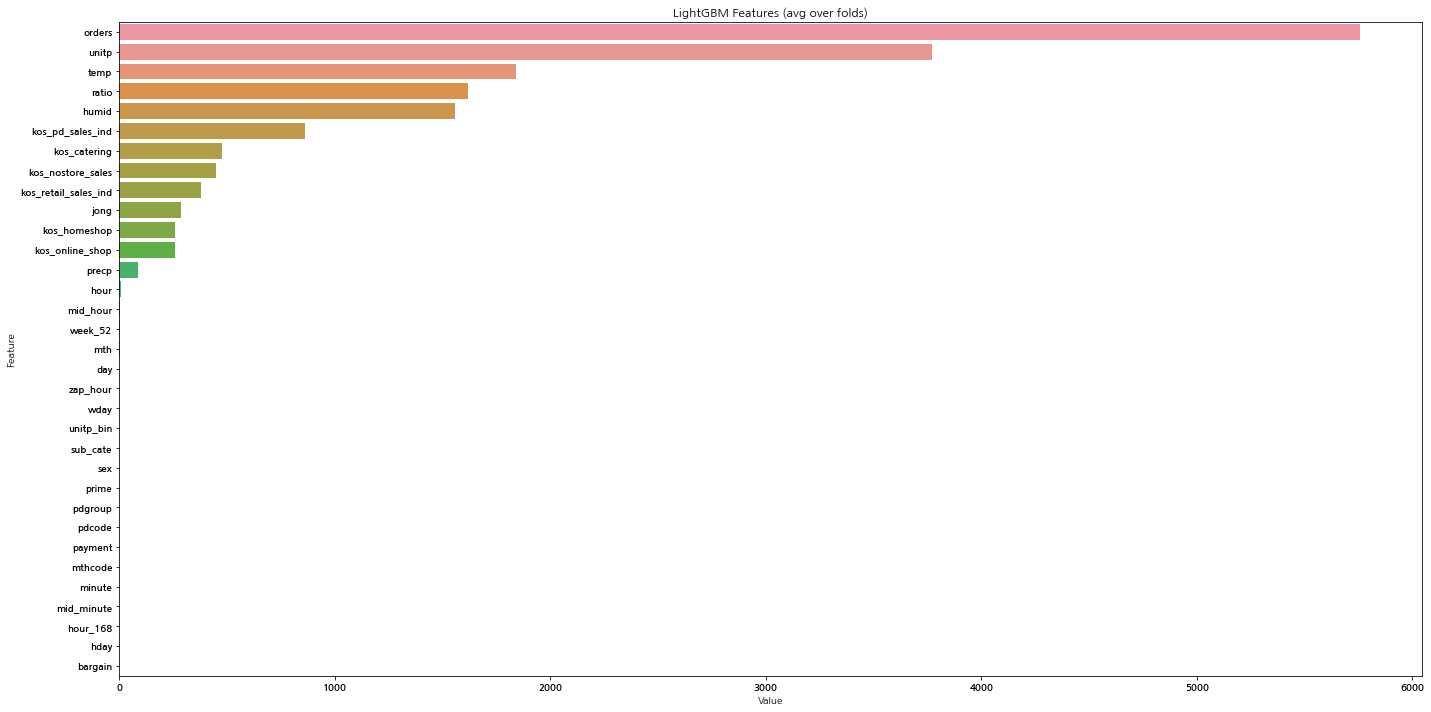

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

### imputation package: impyte, fancyimpute

In [ ]:
# knn
from sklearn.neighbors KNeighborsClassifier

knn = KNeighborsClassifier(3, weights = 'distance')
model_3nn = knn.fit(train_data.drop(['sales'], axis = 1), train_data[['sales']])
missing_sales = train_data['sales'].isnull()
df_missing_sales = pd.DataFrame(train_data[missing_sales])
imputed_sales = model_3nn.predict(df_missing_sales)

In [ ]:
!pip install fancyimpute
# https://github.com/iskandr/fancyimpute

In [ ]:
import sys
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputed_training=fast_knn(train.values, k=30)

from impyute.imputation.cs import mice

# start the MICE training
imputed_training=mice(train.values)

### StratifiedShuffleSplit - sales

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(forest.values, forest_fire.temp_bins.values):
    st_train_set = forest_fire.iloc[train_index]
    st_test_set = forest_fire.iloc[test_index]